# Modeling

In [29]:
import sys
from pathlib import Path

# make sure parent folder (project root) is on the path
project_root = Path.cwd().parent  # adjust if your notebook lives somewhere else
sys.path.insert(0, str(project_root))

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from src.modeling import (
    load_features,
    cross_validate_model,
    summarize_cv_results,
    train_test_evaluate,
    plot_confusion_matrix,
    publish_models
)

# 2. Load data
FEATURES_CSV = "../data/processed/features.csv"
X, targets, feature_cols = load_features(FEATURES_CSV)
print("Features matrix:", X.shape)

Features matrix: (2205, 136)



>>> RF on cooler_pct (5‑fold CV)
    accuracy  : 0.998 ± 0.001
    f1_macro  : 0.998 ± 0.001

>>> RF on cooler_pct (Train/Test split)
    accuracy  : 1.000
    f1_macro  : 1.000


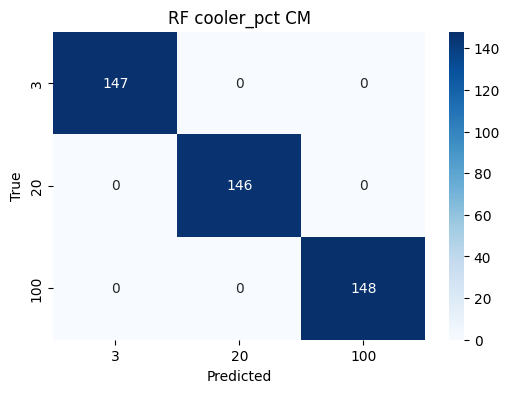


>>> RF on valve_pct (5‑fold CV)
    accuracy  : 0.993 ± 0.002
    f1_macro  : 0.991 ± 0.002

>>> RF on valve_pct (Train/Test split)
    accuracy  : 0.986
    f1_macro  : 0.983


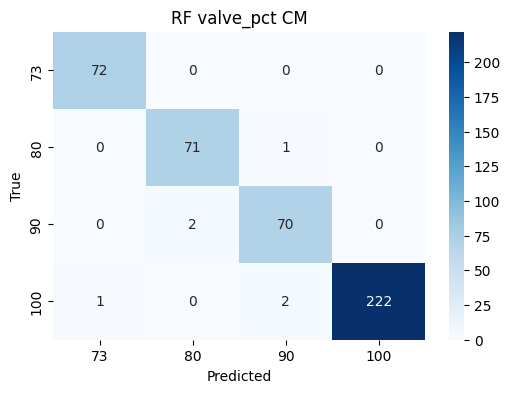


>>> RF on pump_leak (5‑fold CV)
    accuracy  : 0.995 ± 0.002
    f1_macro  : 0.994 ± 0.003

>>> RF on pump_leak (Train/Test split)
    accuracy  : 0.998
    f1_macro  : 0.997


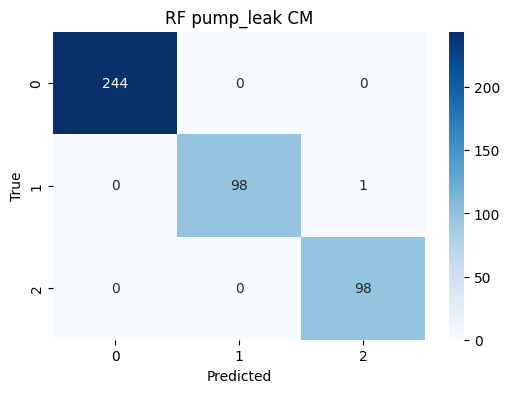


>>> RF on acc_pressure (5‑fold CV)
    accuracy  : 0.986 ± 0.004
    f1_macro  : 0.984 ± 0.004

>>> RF on acc_pressure (Train/Test split)
    accuracy  : 0.968
    f1_macro  : 0.965


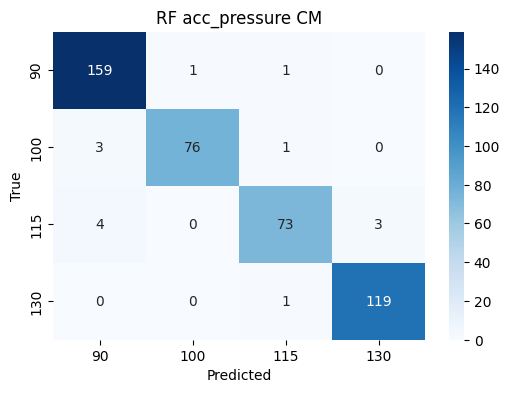


>>> GB on cooler_pct (5‑fold CV)
    accuracy  : 0.999 ± 0.001
    f1_macro  : 0.999 ± 0.001

>>> GB on cooler_pct (Train/Test split)
    accuracy  : 1.000
    f1_macro  : 1.000


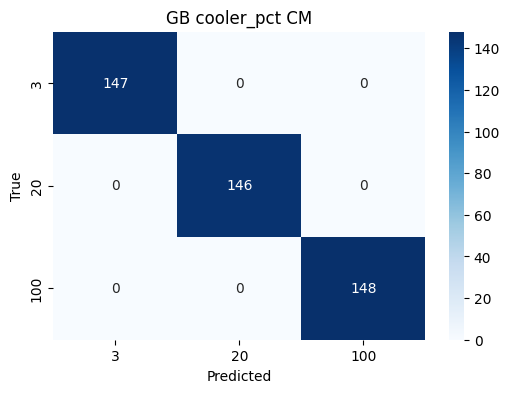


>>> GB on valve_pct (5‑fold CV)
    accuracy  : 0.990 ± 0.004
    f1_macro  : 0.988 ± 0.005

>>> GB on valve_pct (Train/Test split)
    accuracy  : 0.986
    f1_macro  : 0.982


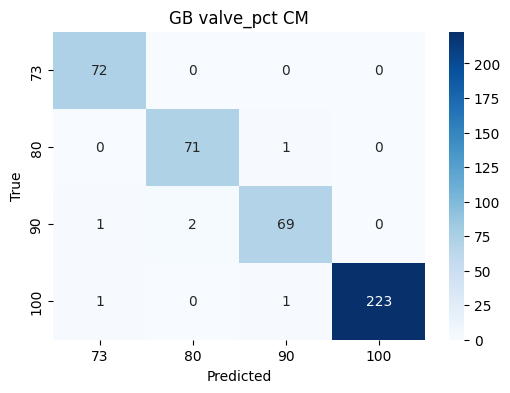


>>> GB on pump_leak (5‑fold CV)
    accuracy  : 0.992 ± 0.005
    f1_macro  : 0.989 ± 0.007

>>> GB on pump_leak (Train/Test split)
    accuracy  : 0.995
    f1_macro  : 0.993


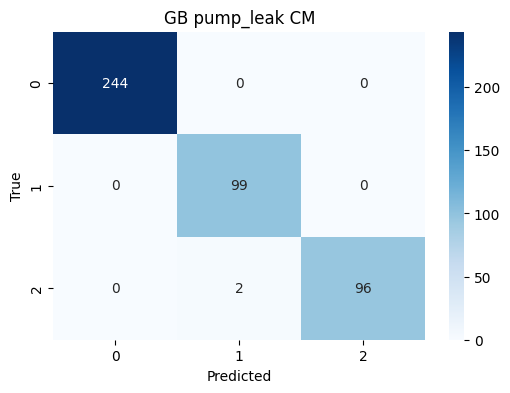


>>> GB on acc_pressure (5‑fold CV)
    accuracy  : 0.979 ± 0.008
    f1_macro  : 0.975 ± 0.010

>>> GB on acc_pressure (Train/Test split)
    accuracy  : 0.964
    f1_macro  : 0.959


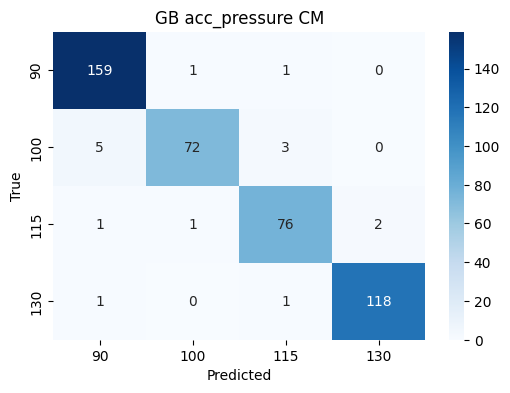

In [30]:
# 3. Define candidate models
model_defs = [
    (RandomForestClassifier(n_estimators=100, random_state=42), "rf"),
    (GradientBoostingClassifier(n_estimators=100, random_state=42), "gb")
]

# 4. Evaluate via CV and train/test, then collect for publishing
models_to_publish = {}

for model, label in model_defs:
    for tgt_name, y in targets.items():
        # 4a) Cross‑validation
        cv_res = cross_validate_model(model, X, y)
        cv_summary = summarize_cv_results(cv_res)
        print(f"\n>>> {label.upper()} on {tgt_name} (5‑fold CV)")
        for metric, (mean, std) in cv_summary.items():
            print(f"    {metric:10s}: {mean:.3f} ± {std:.3f}")
        
        # 4b) Single train/test split
        out = train_test_evaluate(model, X, y)
        print(f"\n>>> {label.upper()} on {tgt_name} (Train/Test split)")
        for metric, val in out['metrics'].items():
            print(f"    {metric:10s}: {val:.3f}")
        plot_confusion_matrix(
            out['confusion_matrix'], 
            out['labels'], 
            title=f"{label.upper()} {tgt_name} CM"
        )
        
        # 4c) Collect the fitted model for publishing
        models_to_publish[f"{label}_{tgt_name}"] = out['model']